In [2]:
import os
if "ntbk" in os.getcwd():
    os.chdir("..")
print(os.getcwd())

import sys
sys.path.append(os.path.join(os.getcwd(), "otgnn"))
sys.path.append(os.path.join(os.getcwd(), "molgen"))
sys.path.append(os.path.join(os.getcwd(), "iclr19-graph2graph/props"))


%load_ext autoreload
%autoreload 2

from otgnn.models import GCN
# from molgen.dataloading.MolGraphBatchPreprocessor import MolGraph
from otgnn.graph import MolGraph
from otgnn.utils import save_model, load_model
from otgnn.graph import SYMBOLS, FORMAL_CHARGES, BOND_TYPES


from mol_opt.data_mol_opt import MolOptDataset
from mol_opt.data_mol_opt import get_loader
from mol_opt.arguments import get_args
from mol_opt.train_mol_opt import main, load_checkpoint, initialize_models
from mol_opt.mol_opt import MolOpt
from mol_opt.decoder_mol_opt import MolOptDecoder
from mol_opt.ot_utils import encode_target
from mol_opt.ot_utils import FGW 
from mol_opt.ot_utils import compute_barycenter

from molgen.dataloading.feat2smiles import feat2smiles
from molgen.dataloading.mol_drawer import MolDrawer
from molgen.metrics.Penalty import Penalty
from molgen.metrics.mol_metrics import MolMetrics
from molgen.Discretizer.sinkhorn import sinkhorn_knopp

from rdkit.Chem import MolFromSmiles
from tensorboardX import SummaryWriter

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import grad
import numpy as np
import time
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from molgen.metrics.Penalty import Penalty as PenaltyNew
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('dark_background')

/home/octav/gitrepos/tum-thesis
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
model_type = "deepsets"
sys.argv = ["", "-model_type", model_type, "-one_batch_train"]
args = get_args()
args.n_epochs = 100 
# args.init_model = "{}-attention-random-gcn2-sink1-test13".format(model_type)
args.init_model = "{}-attention-sink6-test8".format(model_type)
# args.output_dir = "/home/octav/gitrepos/tum-thesis/mol_opt/output_dev4/{}/".format(args.init_model)
args.output_dir = "/run/media/octav/data-volume/tum-thesis/output_dev4_saves/{}/".format(args.init_model)
args.tb_logs_dir = "/home/octav/gitrepos/tum-thesis/mol_opt/logs_dev4/{}".format(args.init_model)
args.batch_size = 50 

image_dir = "/home/octav/Dropbox/Apps/Overleaf/TUM Thesis/figures/"

In [4]:
model = args.init_model
model_iter = 2000

model_name = "model_{}_{}".format(model, model_iter)
print(args.output_dir + model_name)

molopt, molopt_decoder, _, pen, recpen, crossatt, _, config, _ = load_checkpoint(args.output_dir + model_name ,init_fc = initialize_models, device = args.device)

metrics = MolMetrics(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, False, device = args.device)
fgw_loss = FGW(alpha = 0.5)
# pen = PenaltyNew(config, model_iter)

molopt_module_list = torch.nn.ModuleList([molopt, molopt_decoder])

# molopt = MolOpt(args)
# molopt_decoder = MolOptDecoder(args)
print (molopt)
print (molopt_decoder)
print(molopt.args.model_type)
pen.log()

/run/media/octav/data-volume/tum-thesis/output_dev4_saves/deepsets-attention-sink6-test8/model_deepsets-attention-sink6-test8_2000
MolOpt(
  (GCN): GCN(
    (W_message_i): Linear(in_features=100, out_features=200, bias=False)
    (W_message_h): Linear(in_features=200, out_features=200, bias=False)
    (W_message_o): Linear(in_features=293, out_features=150, bias=True)
    (W_mol_h): Linear(in_features=150, out_features=100, bias=True)
    (W_mol_o): Linear(in_features=100, out_features=1, bias=True)
    (dropout_gcn): Dropout(p=0.0, inplace=False)
    (dropout_ffn): Dropout(p=0.0, inplace=False)
  )
  (opt0): Linear(in_features=300, out_features=200, bias=True)
  (opt1): Linear(in_features=200, out_features=150, bias=True)
)
MolOptDecoder(
  (fc1_SYMBOLS): Linear(in_features=150, out_features=150, bias=True)
  (fc2_SYMBOLS): Linear(in_features=150, out_features=64, bias=True)
  (fc1_CHARGES): Linear(in_features=150, out_features=150, bias=True)
  (fc2_CHARGES): Linear(in_features=150, 

In [5]:
# train_data_loader = get_loader("iclr19-graph2graph/data/qed", "train_pairs", args.batch_size, True)
datatype = "train"
train_data_loader = get_loader("molgen/data/chembl50", datatype, 50, same_number_atoms = True)

for i in train_data_loader:
#     X = (MolGraph(i[0]))
#     Y = (MolGraph(i[1]))
    X = MolGraph(i)
    Y = X
    break

In [10]:
x_encoding, x_embedding = molopt.forward(X)
yhat_logits = molopt_decoder.forward(x_embedding, X, Y)
yhat_labels = molopt_decoder.discretize_argmax(*yhat_logits)
# yhat_labels = molopt_decoder.discretize_gumbel(*yhat_logits, tau = pen.tau)
pred_pack = (yhat_labels, yhat_logits, Y.scope), Y 

target = Y.get_graph_outputs()
symbols_labels, charges_labels, bonds_labels = yhat_labels
symbols_logits, charges_logits, bonds_logits = yhat_logits

pen.mirror = ""

if config.cross_att_use:
    if config.cross_att_use_gcn2:
        y_encoding = molopt.GCN2(Y)[0]
    else:
        y_encoding = molopt.GCN(Y)[0]
    cross_mats, ot_loss = crossatt.forward(x_embedding, y_encoding, X, model_type)
    fgw_loss_item = fgw_loss(*pred_pack, tau = 1, ot_plans = cross_mats, atoms = args.fgw_atoms, bonds = args.fgw_bonds)
#     cross_mats = crossatt.forward(x_embedding, y_encoding, X, model_type)
#     fgw_loss_item = fgw_loss(*pred_pack, tau = 1, ot_plans = cross_mats)
else:
    fgw_loss_item = fgw_loss(*pred_pack, tau = 1)

pen.tau = 0.05
print (fgw_loss_item.item()/args.batch_size)
pen_loss = pen(*pred_pack, model_iter)
# print (pen_loss, ot_loss.item()/args.batch_size)
metrics.measure_batch(pred_pack[0], target)

/home/octav/gitrepos/tum-thesis/otgnn/models/gromov_modules.py:398: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  nce_reg = torch.nn.LogSoftmax()(torch.stack(all_nce_dists))[0]


0.5194847106933593


({'batch_molecular_validity': 2.0,
  'batch_correctness': 0.0,
  'batch_symbol_accuracy': 91.73913043478261,
  'batch_molecular_disconnected_validity': 20.0,
  'batch_connected_components': 5.28,
  'batch_invalid_valency_nodes': 20.608695652173914,
  'batch_nodes_0degree': 145,
  'batch_nodes_7plus_degree': 4,
  'invalid_euler_toofew': 12.0,
  'invalid_euler_toomany': 22.0},
 {'avg_euler_error': (1.9599999999999995, 50, 38.278400000000005),
  'batch_node_degree': (2.173913043478262, 1150, 2.075841209829868)})

In [11]:
for i in molopt.GCN.parameters():
    print (i)

Parameter containing:
tensor([[-0.0371,  0.0117, -0.0171,  ..., -0.0763, -0.0752, -0.0074],
        [-0.1155, -0.0334, -0.0929,  ...,  0.0724, -0.0389, -0.0746],
        [-0.1969, -0.0075, -0.0036,  ..., -0.0917, -0.0983, -0.0492],
        ...,
        [-0.0467, -0.0011, -0.0127,  ...,  0.0099, -0.1061,  0.0445],
        [-0.1313, -0.0510,  0.2195,  ...,  0.0786, -0.2386, -0.0254],
        [-0.0543, -0.1075, -0.0742,  ..., -0.0062, -0.1191, -0.0142]],
       requires_grad=True)
Parameter containing:
tensor([[ 0.0635,  0.0124,  0.0149,  ...,  0.0058, -0.0746, -0.0121],
        [ 0.0102, -0.0057,  0.0201,  ..., -0.0570, -0.0395,  0.0240],
        [-0.0423, -0.0003, -0.0683,  ..., -0.0697,  0.0129, -0.0128],
        ...,
        [-0.0176, -0.0882, -0.0506,  ..., -0.0408, -0.0054,  0.0265],
        [ 0.0504,  0.0063,  0.0052,  ..., -0.0084, -0.0321, -0.0866],
        [ 0.0074, -0.0742,  0.0134,  ...,  0.0265,  0.0238, -0.0556]],
       requires_grad=True)
Parameter containing:
tensor([[-0.

In [12]:
fgw_loss_item

tensor(25.9742, grad_fn=<AddBackward0>)

In [13]:
# adjM = pen_loss
# N = adjM.shape[0]
# device = adjM.device
# cap_value = 1e-02
# 
# L = torch.diag(torch.matmul(adjM, torch.ones(N, device=device))) - adjM # Laplacian
# L_mod = L + torch.ones_like(L, device=device) / N
# eigenvals = torch.symeig(L_mod, eigenvectors=True)[0] # IMPORTANT: need to compute eigenvectors for autograd
# capped = torch.clamp(eigenvals, min=1e-6, max=1e-02)
# print (eigenvals)
# -torch.sum(torch.log(capped)) + len(eigenvals) * np.log(cap_value)

In [14]:
print([x.item() / args.batch_size for x in pen_loss])
print(bonds_labels.unique(return_counts = True))

[0.47917633056640624, 1.4889651489257814, 0.7859767150878906]
(tensor([0, 2, 4]), tensor([ 2494,     2, 27012]))


In [15]:
target_bond_counts = torch.zeros(len(BOND_TYPES))
for i in range(len(target)):
    target_bond_counts += target[i]["BOND_TYPES"].sum(axis = (0,1))
print(target_bond_counts.int())

tensor([ 1768,   716,     4,     0, 27020], dtype=torch.int32)


In [16]:
y_embedding = y_encoding
yhat_embedding = x_embedding

def hmap(dfr, savename = None, image_dir = image_dir):
    sns.heatmap(dfr.cpu().detach().numpy(), cmap = sns.color_palette("rocket_r", as_cmap=True))
    if savename is not None:
        plt.savefig(os.path.join(image_dir, savename))
    plt.show()
    
def project_2d(dfr):
    yhat_np = dfr.cpu().detach().numpy()
    yhat_mean = np.mean(yhat_np.T, axis = 1)
    yhat_nomean = yhat_np - yhat_mean
    cov = np.cov(yhat_nomean.T)
    values, vectors = np.linalg.eig(cov)
    proj = vectors[:,:2].T.dot(yhat_nomean.T)
    return proj

0
1
2
Model name: model_deepsets-attention-sink6-test8_2000
Type=deepsets, random=False, epoch=2000, index=2
M


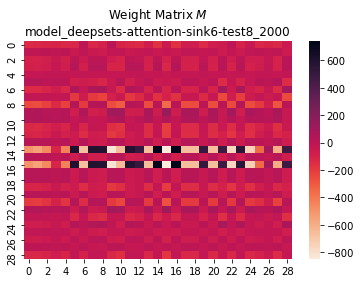

attn


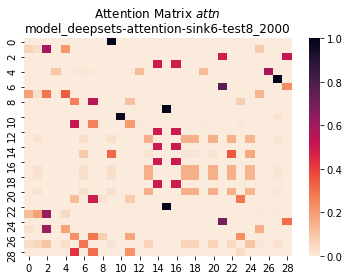

W 0


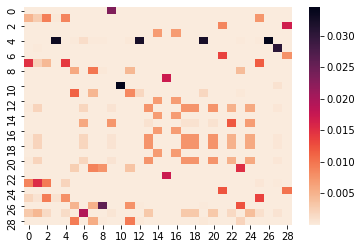

tensor([0.0345, 0.0345, 0.0345, 0.0345, 0.0345, 0.0345, 0.0345, 0.0345, 0.0345,
        0.0345, 0.0345, 0.0345, 0.0345, 0.0345, 0.0345, 0.0345, 0.0345, 0.0345,
        0.0345, 0.0345, 0.0345, 0.0345, 0.0345, 0.0345, 0.0345, 0.0345, 0.0345,
        0.0345, 0.0345], grad_fn=<SumBackward1>)
tensor([0.0234, 0.0336, 0.0254, 0.0138, 0.1346, 0.0307, 0.0212, 0.0477, 0.0251,
        0.0172, 0.0351, 0.0287, 0.0138, 0.0469, 0.0138, 0.0361, 0.0138, 0.0469,
        0.0469, 0.0138, 0.0469, 0.0379, 0.0172, 0.0369, 0.0223, 0.0345, 0.0569,
        0.0514, 0.0275], grad_fn=<SumBackward1>)

Mgrad


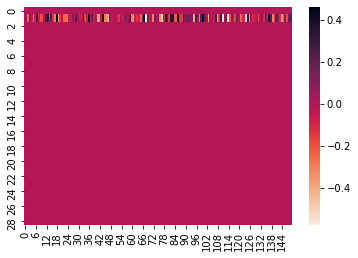

attgrad


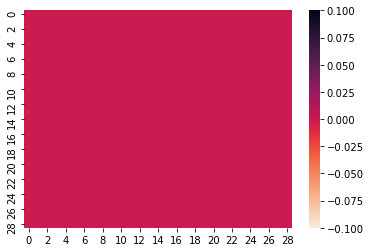

Wgrad


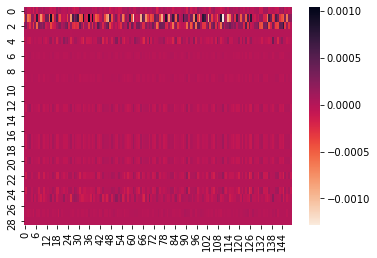

lossgrad


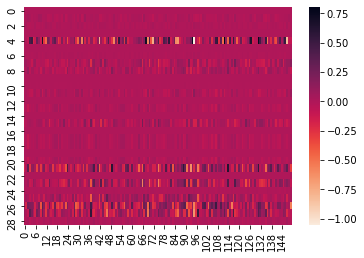

In [18]:
cross_mats = []
loss = torch.tensor(0.)
for idx, (stx, lex) in enumerate(X.scope):
    print (idx)
    if idx < 2:
        continue
    y = y_embedding[stx:stx+lex]
    # these things vary because of the different types of embedding for diff models
    if model_type == "deepsets":
        yhat = yhat_embedding[stx:stx+lex]
    elif model_type == "molemb":
        yhat = yhat_embedding[idx][:lex]
    # print(y.shape, self.k.shape, self.q.shape, yhat.shape)
#     M = 1/np.sqrt(crossatt.cross_att_dim) * torch.matmul(torch.matmul(y, crossatt.k), torch.matmul(crossatt.q.T, yhat.T))
#     M = torch.matmul(crossatt.k1(F.leaky_relu(crossatt.k0(y))), crossatt.q1(F.leaky_relu(crossatt.q0(yhat))).T)
    if config.cross_att_use_gcn2:
        M = torch.matmul(y, crossatt.q1(F.leaky_relu(crossatt.q0(yhat))).T)
    else:
        M = torch.matmul(crossatt.k1(F.leaky_relu(crossatt.k0(y))), crossatt.q1(F.leaky_relu(crossatt.q0(yhat))).T)
#     M = M.clamp(-5, 5)
    if config.cross_att_sigmoid:
        M = nn.Sigmoid()(M) * 5
    
    print ("Model name:", model_name)
    print ("Type={}, random={}, epoch={}, index={}".format(model_type, config.cross_att_random, model_iter, idx))
    if crossatt.args.cross_att_random:
        dim = np.random.randint(2)
        print ("random dim selected", dim)
    else:
        dim = 1
        
    print ("M")
    plt.title("Weight Matrix $M$ \n{}".format(model_name))
    hmap(M, model_name + "_M")


    attn = torch.softmax(M, dim = dim)
    loss_vec = attn.sum(axis = 1 - dim)
    loss += torch.sum(-torch.log(loss_vec) * loss_vec)
    print ("attn")
    plt.title("Attention Matrix $attn$ \n{}".format(model_name))
    hmap(attn, model_name + "_attn")
    W = (attn + crossatt.eps)/(len(attn))
    # if idx == 0:
    #     print (W.sum(axis = 0))
    #     print (W.sum(axis = 1))
    #     print ()
#     W2 = sinkhorn_knopp(W, -0.1, numItermax=1)
#     print ("new sinkhorn")
#     hmap(W2)
#     if idx == 0:
#         print (W2.sum(axis = 0))
#         print (W2.sum(axis = 1))
#         print ()
    
    W_in = W
#     for idx2 in range(crossatt.args.cross_att_n_sinkhorn):
    for idx2 in range(1):
        dim = 1 - dim
        W = (W.transpose(0,dim) / W.sum(axis = dim)).transpose(0,dim)
        W = W/(len(W))
#         if idx2 == crossatt.args.cross_att_n_sinkhorn-1:
        if True:
            print ("W",idx2)
            hmap(W)
            print (W.sum(axis = 0))
            print (W.sum(axis = 1))
            print ()
#     print ("W",idx2+1)
#     hmap(W)
    
    cross_mats.append(W)
    
    print ("Mgrad")
    hmap(grad(M[1,1], yhat, retain_graph = True)[0])
    
    print ("attgrad")
    hmap(grad(attn[0,0], M, retain_graph = True)[0])
    
    print ("Wgrad")
    hmap(grad(W[1,1], yhat, retain_graph = True)[0])
    
#     print ("W2grad")
#     hmap(grad(W2[1,1], W, retain_graph = True)[0])

    print ('lossgrad')
    hmap(grad(loss, y, retain_graph = True)[0])
    
    break

In [19]:
print (loss)
loss_vec

tensor(-7.1839, grad_fn=<AddBackward0>)


tensor([0.4597, 0.4322, 2.2297, 0.0973, 0.8316, 1.5604, 0.5210, 1.8939, 0.0943,
        1.4756, 0.9781, 0.8037, 0.1377, 0.6792, 2.5058, 2.0001, 2.5058, 0.6792,
        0.6792, 0.1377, 0.6792, 1.9457, 0.9951, 0.6434, 0.8450, 0.4074, 0.5974,
        1.1263, 1.0583], grad_fn=<SumBackward1>)

In [20]:
loss_vec = W.sum(axis = 1-dim)
print (torch.sum(-torch.log(loss_vec) * loss_vec))
print (torch.sum(-torch.log(loss_vec + crossatt.eps) * loss_vec))

tensor(3.2012, grad_fn=<SumBackward0>)
tensor(3.2011, grad_fn=<SumBackward0>)


In [21]:
nn.Sigmoid()(M)

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         9.9363e-01, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.1525e-31, 0.0000e+00, 6.7097e-24, 0.0000e+00, 1.1525e-31,
         1.1525e-31, 0.0000e+00, 1.1525e-31, 1.2308e-24, 8.6083e-01, 0.0000e+00,
         5.2410e-17, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.5294e-24],
        [4.2154e-03, 2.2314e-03, 3.6882e-02, 4.9043e-05, 1.3483e-02, 7.9874e-21,
         1.5966e-05, 3.9796e-21, 8.3029e-25, 4.9499e-10, 1.6090e-07, 5.1156e-21,
         1.9909e-15, 1.0179e-05, 6.3062e-21, 6.0783e-13, 6.3062e-21, 1.0179e-05,
         1.0179e-05, 1.9909e-15, 1.0179e-05, 3.7115e-27, 1.5179e-08, 9.0591e-23,
         1.8516e-06, 5.6627e-03, 1.3445e-07, 8.0032e-05, 6.7717e-27],
        [0.0000e+00, 0.0000e+00, 1.0744e-35, 2.2651e-21, 3.7036e-36, 3.1168e-02,
         1.1706e-23, 1.0537e-02, 9.9268e-01, 2.9119e-30, 0.0000e+00, 2.5659e-02,
         1.8813e-07, 2.3137e-38, 5.5886e-03, 0.000

In [22]:
loss_vec = attn.sum(axis = 0)
torch.sum(-torch.log(loss_vec) * loss_vec)

tensor(-7.1839, grad_fn=<SumBackward0>)

In [23]:
attn.sum(axis = 0)

tensor([0.4597, 0.4322, 2.2297, 0.0973, 0.8316, 1.5604, 0.5210, 1.8939, 0.0943,
        1.4756, 0.9781, 0.8037, 0.1377, 0.6792, 2.5058, 2.0001, 2.5058, 0.6792,
        0.6792, 0.1377, 0.6792, 1.9457, 0.9951, 0.6434, 0.8450, 0.4074, 0.5974,
        1.1263, 1.0583], grad_fn=<SumBackward1>)

In [24]:
nn.Sigmoid()(M)

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         9.9363e-01, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.1525e-31, 0.0000e+00, 6.7097e-24, 0.0000e+00, 1.1525e-31,
         1.1525e-31, 0.0000e+00, 1.1525e-31, 1.2308e-24, 8.6083e-01, 0.0000e+00,
         5.2410e-17, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.5294e-24],
        [4.2154e-03, 2.2314e-03, 3.6882e-02, 4.9043e-05, 1.3483e-02, 7.9874e-21,
         1.5966e-05, 3.9796e-21, 8.3029e-25, 4.9499e-10, 1.6090e-07, 5.1156e-21,
         1.9909e-15, 1.0179e-05, 6.3062e-21, 6.0783e-13, 6.3062e-21, 1.0179e-05,
         1.0179e-05, 1.9909e-15, 1.0179e-05, 3.7115e-27, 1.5179e-08, 9.0591e-23,
         1.8516e-06, 5.6627e-03, 1.3445e-07, 8.0032e-05, 6.7717e-27],
        [0.0000e+00, 0.0000e+00, 1.0744e-35, 2.2651e-21, 3.7036e-36, 3.1168e-02,
         1.1706e-23, 1.0537e-02, 9.9268e-01, 2.9119e-30, 0.0000e+00, 2.5659e-02,
         1.8813e-07, 2.3137e-38, 5.5886e-03, 0.000

In [25]:
# get cross entropy loss
loss = nn.CrossEntropyLoss()
loss_vec = attn.sum(axis = 1 - dim)
# loss_vec
# loss(loss_vec, loss_vec)

In [26]:
torch.matmul(y, crossatt.k)

ModuleAttributeError: 'CrossAttUnit' object has no attribute 'k'

In [27]:
torch.matmul(crossatt.q.T, yhat.T)

ModuleAttributeError: 'CrossAttUnit' object has no attribute 'q'

In [28]:
cross_mats[0]

tensor([[7.5011e-08, 7.9772e-08, 1.5465e-08, 3.5441e-07, 4.1466e-08, 2.2099e-08,
         1.1040e-07, 1.8207e-08, 3.6541e-07, 2.3368e-02, 3.5253e-08, 4.2903e-08,
         2.5030e-07, 5.0769e-08, 1.3761e-08, 1.7240e-08, 1.3761e-08, 5.0769e-08,
         5.0769e-08, 2.5030e-07, 5.0769e-08, 1.7722e-08, 3.5571e-08, 5.3592e-08,
         4.0806e-08, 8.4630e-08, 5.7722e-08, 3.0616e-08, 3.2583e-08],
        [4.9374e-03, 2.7740e-03, 9.2084e-03, 2.7063e-04, 8.8116e-03, 2.2099e-08,
         1.6497e-05, 1.8207e-08, 3.6541e-07, 2.3548e-08, 1.2345e-07, 4.2903e-08,
         2.5030e-07, 8.0862e-06, 1.3761e-08, 1.7240e-08, 1.3761e-08, 8.0862e-06,
         8.0862e-06, 2.5030e-07, 8.0862e-06, 1.7722e-08, 4.2832e-08, 5.3592e-08,
         1.2156e-06, 7.4939e-03, 1.7839e-07, 3.8132e-05, 3.2583e-08],
        [7.5011e-08, 7.9772e-08, 1.5465e-08, 3.5441e-07, 4.1466e-08, 2.3329e-08,
         6.6188e-08, 1.8542e-08, 8.6141e-05, 2.3368e-08, 3.5253e-08, 4.4858e-08,
         2.5030e-07, 5.0769e-08, 1.3895e-08, 1.724

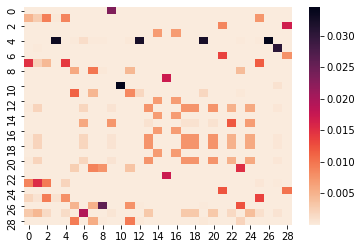

In [29]:
hmap(cross_mats[0])

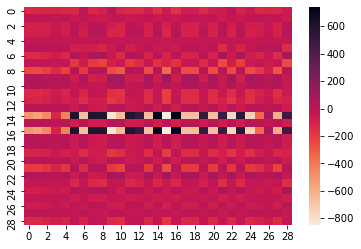

In [30]:
hmap(M)
plt.show()

In [31]:
hmap(torch.matmul(y, crossatt.k))

ModuleAttributeError: 'CrossAttUnit' object has no attribute 'k'

In [32]:
hmap(torch.matmul(crossatt.q.T, yhat.T))

ModuleAttributeError: 'CrossAttUnit' object has no attribute 'q'

/home/octav/anaconda3/envs/mol_ot/lib/python3.6/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


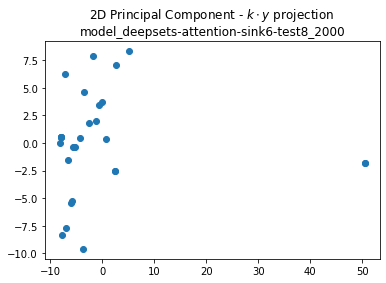

In [34]:
# proj = project_2d(torch.matmul(y, crossatt.k))

# K * Y (GCN embedding)
proj = project_2d(crossatt.k1(F.leaky_relu(crossatt.k0(y))))
# proj = project_2d(torch.matmul(y, crossatt.k))
plt.scatter(proj[0], proj[1])
plt.title("2D Principal Component - $k\cdot y$ projection \n{}".format(model_name))
plt.savefig(os.path.join(image_dir, model_name + "_ky"))
plt.show()

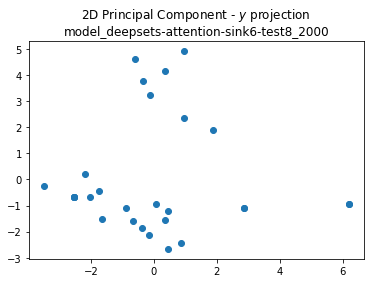

In [35]:
# Y (GCN embedding)
proj = project_2d(y)
plt.scatter(proj[0], proj[1])
plt.title("2D Principal Component - $y$ projection \n{}".format(model_name))
plt.savefig(os.path.join(image_dir, model_name + "_y"))
plt.show()

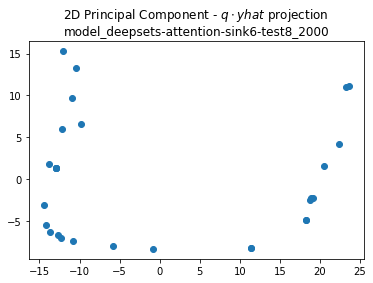

In [40]:
# Q * Yhat (barycenter embedding)
proj = project_2d(crossatt.q1(F.leaky_relu(crossatt.q0(yhat))))
# proj = project_2d(torch.matmul(crossatt.q.T, yhat.T).T)
plt.title("2D Principal Component - $q\cdot yhat$ projection \n{}".format(model_name))
plt.scatter(proj[0], proj[1])
plt.savefig(os.path.join(image_dir, model_name + "_qyhat"))
plt.show()

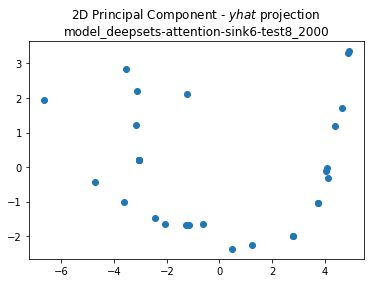

In [37]:
# Yhat (barycenter embedding)
proj = project_2d(yhat)
plt.scatter(proj[0], proj[1])
plt.title("2D Principal Component - $yhat$ projection \n{}".format(model_name))
plt.savefig(os.path.join(image_dir, model_name + "_yhat"))
plt.show()

In [224]:
# check out errors from the penalty terms
M_fgw, pred_bonds_nll, target_bonds_rescaled = fgw_loss(*pred_pack, tau = 1, ot_plans = cross_mats, debug = True)

TypeError: __call__() got an unexpected keyword argument 'debug'

In [ ]:
hmap(M_fgw)

In [ ]:
hmap(W * M_fgw)

In [ ]:
pred_bonds_nll.shape

In [ ]:
target_bonds_rescaled.shape

In [ ]:
y.shape

In [ ]:
crossatt.k.shape

In [ ]:
proj = project_2d(torch.matmul(crossatt.q.T, yhat.T))
plt.scatter(proj[0], proj[1])
plt.show()

In [ ]:
hmap(crossatt.q)

In [ ]:
hmap(crossatt.k)

In [ ]:
hmap(y)

In [ ]:
hmap(yhat)

In [ ]:
cross_mats[0].sum(axis = 0)

In [ ]:
cross_mats[0].sum(axis = 1)

In [ ]:
G_fgw = grad(fgw_loss_item, x_embedding, retain_graph = True)
G_euler = grad(pen_loss[2], bonds_logits, retain_graph = True)
G_k = grad(fgw_loss_item, crossatt.k, retain_graph = True, allow_unused = True)
G_q = grad(fgw_loss_item, crossatt.q, retain_graph = True, allow_unused = True)

print(G_euler[0].abs().mean().item())
print(G_fgw[0].abs().mean().item())
print()
print(np.mean((torch.sum(G_euler[0], dim = 1) == 0).cpu().detach().numpy()))
print(np.mean((torch.sum(G_fgw[0], dim = 1) == 0).cpu().detach().numpy()))
print()
print(symbols_logits.abs().mean().item())
print(bonds_logits.abs().mean().item())

In [ ]:
hmap(grad(cross_mats[idx][0,0], yhat, retain_graph = True)[0])

In [ ]:
grad(cross_mats[idx][0,2], yhat, retain_graph = True)[0]

In [ ]:
grad(crossatt.q[0,0], yhat, retain_graph = True, allow_unused = True)

In [ ]:
crossatt.q

In [ ]:
crossatt.q

# get 2d projections of embedding

In [ ]:
x_embedding.shape

In [ ]:
print ("Model name:", model_name)
print ("Type={}, random={}, epoch={}, index={}".format(model_type, config.cross_att_random, model_iter, idx))
plt.scatter(proj[0], proj[1])
plt.show()

In [ ]:
yhat_np = yhat.cpu().detach().numpy()
yhat_mean = np.mean(yhat_np.T, axis = 1)
yhat_nomean = yhat_np - yhat_mean
cov = np.cov(yhat_nomean.T)
values, vectors = np.linalg.eig(cov)
proj = vectors[:,:2].T.dot(yhat_nomean.T)

In [ ]:
np.linalg.eig(yhat_np)

In [ ]:
yhat_np.shape

In [ ]:
bonds_logits_softmaxed = nn.Softmax(dim = 1)(bonds_logits)

In [ ]:
grad(bonds_logits_softmaxed[:,4].sum(), bonds_logits, retain_graph = True)[0].sum()

In [ ]:
bonds_logits_softmaxed

In [ ]:
x_embedding.shape

In [ ]:
bond_idx = 0
smiles = []

yhat = []
yact = []
for mol_idx, (st, le) in enumerate(Y.scope):
    symbols = symbols_labels[st:st+le]
    charges = charges_labels[st:st+le]
    bonds = bonds_labels[bond_idx:bond_idx+le*le].view(le, le)
    bond_idx += le * le
    smiles.append(feat2smiles(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, symbols, charges, bonds, False))
    yhat.append(le)
    yact.append((bonds != 4).sum().item()/2.)
    print (mol_idx, yact[-1], le)
    print (smiles[-1])
    
yhat = np.array(yhat)
yact = np.array(yact)


In [ ]:
plt.hist(yact - yhat)

In [ ]:
Chem.MolFromSmiles(smiles[1], sanitize = False)

In [ ]:
np.arange(0,1000,100)

In [ ]:
mol_idx = 0 
torch.argmax(target[mol_idx]['SYMBOLS'], dim=1)

In [ ]:
(x_embedding.mean(axis = 0) / x_embedding.std(axis = 0)).abs().max()

In [ ]:
target_smiles = [Chem.MolToSmiles(y) for y in Y.rd_mols]
initial_smiles = [Chem.MolToSmiles(y) for y in X.rd_mols]

# uncomment for tensorboard
tb_writer = SummaryWriter(logdir = args.tb_logs_dir)
mol_drawer = MolDrawer(tb_writer, SYMBOLS, BOND_TYPES, FORMAL_CHARGES)
mol_drawer.visualize_batch(pred_pack[0], target_smiles, model_iter, initial_smiles, text="{}-{}-{}-manual2-".format(args.init_model, model_iter, datatype))

In [ ]:
feat2smiles(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, symbols, charges, bonds, False)

In [ ]:
tau = pen.tau
# tau = 0.001
# symbols_nll, charges_nll, bonds_nll = F.gumbel_softmax(tau = tau, dim=1, logits = symbols_logits), F.gumbel_softmax(tau=tau,dim=1,logits=charges_logits), F.gumbel_softmax(tau=tau,dim=1, logits = bonds_logits)
# symbols_nll, charges_nll, bonds_nll = -nn.LogSoftmax(dim=1)(symbols_logits/tau),\
#              -nn.LogSoftmax(dim=1)(charges_logits/tau), -nn.LogSoftmax(dim=1)(bonds_logits/tau)

def softmax(logits, tau):
#     logitsn = F.normalize(logits, dim = 1)
#     return -nn.LogSoftmax(dim=1)(logitsn/tau)
    return F.gumbel_softmax(tau = tau, dim=1, logits = logits)

symbols_nll = softmax(symbols_logits, tau)
charges_nll = softmax(charges_logits, tau)
bonds_nll = softmax(bonds_logits, tau)

In [ ]:
pen.tau

In [ ]:
plt.hist(symbols_logits.norm(dim = 1).cpu().detach().numpy())

In [ ]:
max_logits = torch.max(F.softmax(dim=1, input = bonds_logits), dim = 1).values.detach().cpu().numpy()
plt.hist(max_logits, bins = 100)

In [ ]:
symbols_logits.shape

In [ ]:
means = symbols_logits.mean(axis = 0).cpu().detach().numpy()
stds = symbols_logits.std(axis = 0).cpu().detach().numpy()
plt.bar(range(len(SYMBOLS)), means, yerr = stds)

In [ ]:
means = bonds_logits.mean(axis = 0).cpu().detach().numpy()
stds = bonds_logits.std(axis = 0).cpu().detach().numpy()
plt.bar(range(len(BOND_TYPES)), means, yerr = stds)

In [ ]:
torch.argmax(F.gumbel_softmax(tau = 1, dim=1, logits = symbols_logits), axis = 1)
# torch.argmax(F.softmax(symbols_logits, dim = 1), axis = 1)

In [ ]:
bonds_logits.sum(axis = 1)

In [ ]:
F.gumbel_softmax(tau = 0.1, dim=1, logits = symbols_logits)

In [ ]:
bonds_nll

In [ ]:
torch.argmax(bonds_nll, dim = 1).unique(return_counts = True)

In [ ]:
bonds_nll

In [ ]:
bond_idx = 0
for st, le in Y.scope:
    bonds_nll_curr = bonds_nll[bond_idx:bond_idx + le**2,:].view(le, le, -1)
    print ((1 - bonds_nll_curr[:,:,4]).sum()/2)
    bond_idx += le**2

In [ ]:
1 - bonds_nll_curr[:,:,4]

In [ ]:
symbols_logits.shape

In [ ]:
symbols_labels

# inspect module parameters

In [ ]:
molopt_decoder.fc1_SYMBOLS

In [ ]:
molopt_decoder.fc2_SYMBOLS(F.leaky_relu(molopt_decoder.fc1_SYMBOLS(x_embedding)))

In [ ]:
x_embedding

# debug connectivity

In [ ]:
def get_pen(model_iter):
    model_name = "model_{}_{}".format(model, model_iter)
    model_decode_name = "model_{}_decode_{}".format(model, model_iter)
    molopt, config = load_model(args.output_dir + model_name, MolOpt, args.device)
    molopt_decoder, config_decoder = load_model(args.output_dir + model_decode_name, MolOptDecoder, args.device)
    x_embedding = molopt.forward(X)
    yhat_logits = molopt_decoder.forward(x_embedding, X, Y)
    yhat_labels = molopt_decoder.discretize_argmax(*yhat_logits)
    # yhat_labels = molopt_decoder.discretize(*yhat_logits)
    pred_pack = (yhat_labels, yhat_logits, Y.scope), Y 

    return (pen(*pred_pack, model_iter)[1].item())

In [ ]:
for i in range(0, 2000):
    print (i, get_pen(1600))

In [ ]:
# adjM = pen_loss
# N = adjM.shape[0]
# device = adjM.device
# # We need the laplacian otherwise
# L = torch.diag(torch.matmul(adjM, torch.ones(N, device=device))) - adjM # Laplacian
# L_mod = L + torch.ones_like(L, device=device) / N
# eigenvals = torch.symeig(L_mod + 1e-06 * torch.eye(N, device=device), eigenvectors=True)[0]
# -torch.sum(torch.log(eigenvals.clamp(max = 1e-01))) + len(eigenvals) * np.log(1e-01)

In [ ]:
F.gumbel_softmax(symbols_logits, dim=1, tau=0.5)